### Import Data

In [81]:
import pandas as pd 

movies_df = pd.read_csv('/workspaces/4Geeks-flask-render-self/data.csv')
movies_df['id'] = movies_df['id'].str.slice(2)
movies_df.head()

,id,title,genres,averageRating,numVotes,releaseYear
0,0111161,The Shawshank Redemption,Drama,9.3,2951083,1994
1,0068646,The Godfather,"Crime, Drama",9.2,2057179,1972
2,0252487,The Chaos Class,Comedy,9.2,43570,1975
3,0259534,Ramayana: The Legend of Prince Rama,"Action, Adventure, Animation",9.2,15407,1993
4,16747572,The Silence of Swastika,"Documentary, History",9.2,10567,2021


In [82]:
movies_df = movies_df.drop(columns=['title'])


In [83]:
# from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer

# movies_df['genre_split'] = movies_df['genres'].str.split(',')

# mlb = MultiLabelBinarizer()
# movies_df_encoded = pd.DataFrame(mlb.fit_transform(movies_df['genre_split']), columns=mlb.classes_, index=movies_df.index)

# movies_df.reset_index(drop=True, inplace=True)
# movies_df_encoded.reset_index(drop=True, inplace=True)

# movies_combined = pd.concat([movies_df, movies_df_encoded], axis=1)
# movies_combined.head()


In [84]:

#movies_df_new = pd.concat([movies_df, movies_combined], axis=1)
# movies_combined = movies_df.drop(columns=['id', 'genres', 'genre_split'])
# movies_combined.head()


### Test Train Split

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder


X = movies_df.drop(columns='averageRating')
# Encode the 'genres' column
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
#X['genres_encoded'] = encoder.fit_transform(X[['genres']])

X = X.drop(columns=['genres', 'id'])
y = movies_df['averageRating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train.columns
print(X_train)




     numVotes  releaseYear
29      13677         2022
535     16716         2022
695     24035         2021
557    885150         2008
836     62264         1925
..        ...          ...
106     23567         2003
270    627181         1997
860     38835         1980
435    122182         2001
102     41729         2008

[800 rows x 2 columns]


### Decision Tree

In [86]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)



DecisionTreeRegressor()

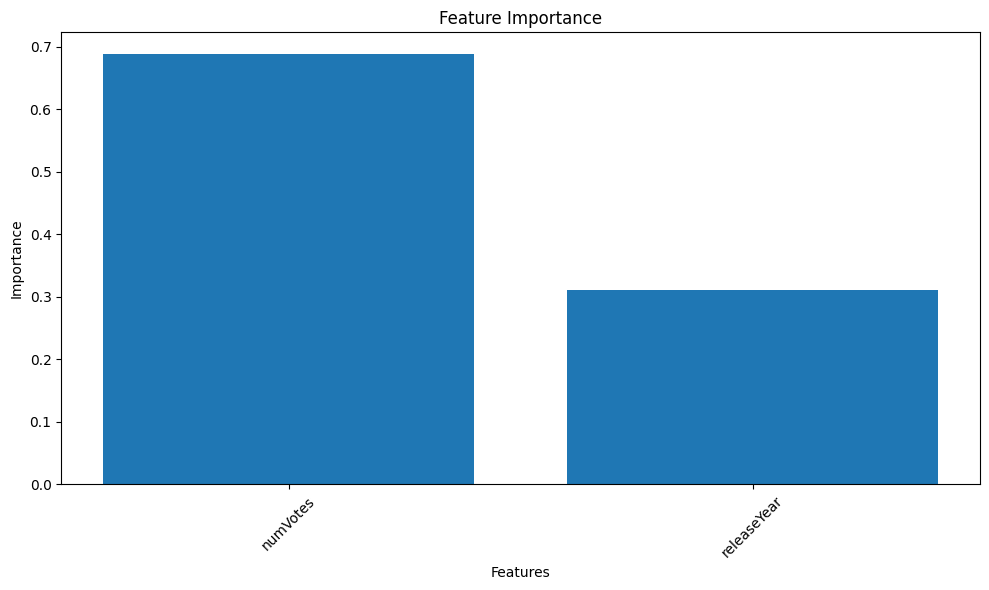

In [87]:
import matplotlib.pyplot as plt

# Ensure the length of the 'feature' list matches the length of 'tree.feature_importances_'
features = X_train.columns.tolist()
feature_importance = pd.DataFrame({'feature': features, 
                                   'importance': tree.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [88]:
from sklearn.model_selection import KFold, cross_val_score


k = 5  # number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)


Cross-validation scores (R-squared):
Fold 1: -0.3358
Fold 2: -0.3547
Fold 3: -0.2973
Fold 4: -0.7252
Fold 5: -0.0401

Mean R-squared: -0.3506 (+/- 0.4380)


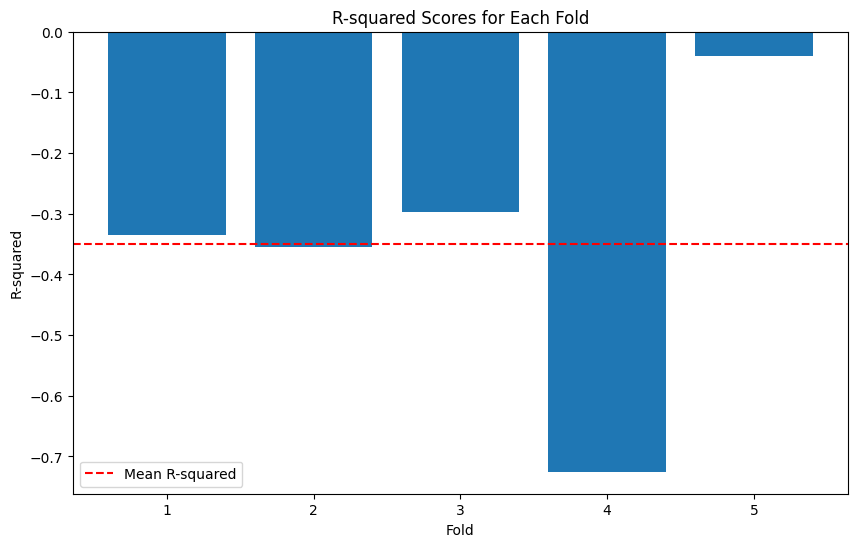

In [89]:
from sklearn.model_selection import KFold, cross_val_score


# Perform cross-validation for R-squared scores
r2_scores = cross_val_score(tree, X, y, cv=kf, scoring='r2')

print('\nCross-validation scores (R-squared):')
for i, score in enumerate(r2_scores):
    print(f'Fold {i+1}: {score:.4f}')
print(f'\nMean R-squared: {r2_scores.mean():.4f} (+/- {r2_scores.std() * 2:.4f})')

# Visualize R-squared results
plt.figure(figsize=(10, 6))
plt.bar(range(1, k+1), r2_scores)
plt.title('R-squared Scores for Each Fold')
plt.xlabel('Fold')
plt.ylabel('R-squared')
plt.axhline(y=r2_scores.mean(), color='r', linestyle='--', label='Mean R-squared')
plt.legend()
plt.show()

In [90]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

#Set up randomized search
random_search = RandomizedSearchCV(
    estimator=tree,
    param_distributions=param_dist,
    n_iter=100,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='r2',  # Use R-squared as the scoring metric
    random_state=42,
    n_jobs=-1
)

# Fit the random search model
random_search.fit(X, y)

# Print the best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best R-squared score found: ", random_search.best_score_)

# Get the best model
best_model = random_search.best_estimator_

Best parameters found:  {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 7}
Best R-squared score found:  0.19827838727663283


/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
170 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
170 fits failed with the following error:
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/hom

In [91]:
random_search = DecisionTreeRegressor(min_samples_leaf=2, min_samples_split=10, max_features='sqrt', max_depth=5)
random_search.fit(X_train, y_train)




DecisionTreeRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=10)

In [92]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score

tree_2 = DecisionTreeRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=10)
tree_2.fit(X_train, y_train)

y_pred = tree_2.predict(X_test)
score = r2_score(y_test, y_pred)

print("R2: " + str(score))


R2: 0.09124252473602468


In [93]:
import math
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print("MSE: " + str(mse))
print("MSE sqrt: " + str(math.sqrt(mse)))

MSE: 0.04905018472737305
MSE sqrt: 0.2214727629469887



Cross-validation scores (R-squared):
Fold 1: 0.0765
Fold 2: 0.1642
Fold 3: 0.2489
Fold 4: -0.0248
Fold 5: 0.1541

Mean R-squared: 0.1238 (+/- 0.1844)


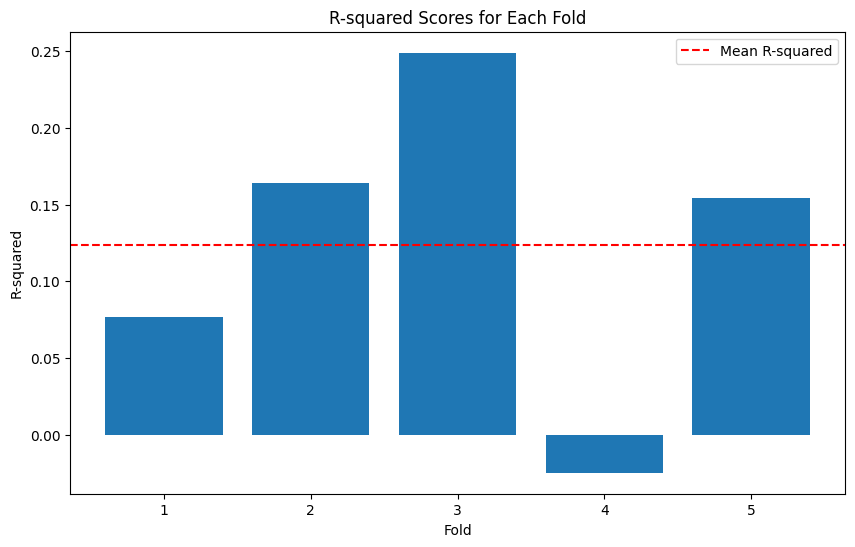

In [94]:
from sklearn.model_selection import KFold, cross_val_score


# Perform cross-validation for R-squared scores
r2_scores = cross_val_score(random_search, X, y, cv=kf, scoring='r2')

print('\nCross-validation scores (R-squared):')
for i, score in enumerate(r2_scores):
    print(f'Fold {i+1}: {score:.4f}')
print(f'\nMean R-squared: {r2_scores.mean():.4f} (+/- {r2_scores.std() * 2:.4f})')

# Visualize R-squared results
plt.figure(figsize=(10, 6))
plt.bar(range(1, k+1), r2_scores)
plt.title('R-squared Scores for Each Fold')
plt.xlabel('Fold')
plt.ylabel('R-squared')
plt.axhline(y=r2_scores.mean(), color='r', linestyle='--', label='Mean R-squared')
plt.legend()
plt.show()

In [95]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [None, 10, 20, 30],             # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],             # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],               # Minimum number of samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2']       # Number of features to consider for the best split
}


# Step 5: Setup GridSearchCV
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, 
                           cv=5, scoring='r2', verbose=2, n_jobs=-1)

# Step 6: Fit the Grid Search to the training data
grid_search.fit(X_train, y_train)

# Step 7: View the best hyperparameters and the best score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best R-squared Score:", grid_search.best_score_)

# Step 8: Test the model with the best hyperparameters
best_rf = grid_search.best_estimator_
test_score = best_rf.score(X_test, y_test)
print("Test R-squared Score:", test_score)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s


[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1,

In [96]:
#%pip install xgboost
from xgboost import XGBRegressor 


xgb = XGBRegressor()
xgb.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [97]:

y_pred = xgb.predict(X_test)
xgb.score(X_test, y_test)


0.011680870814981814

Average error im off of my predictions is .2 (r2)


In [98]:
import pickle 

# Save the trained model to a file
with open('movies_xgb_model.sav', 'wb') as file:
    pickle.dump('movies.ipynb', file)

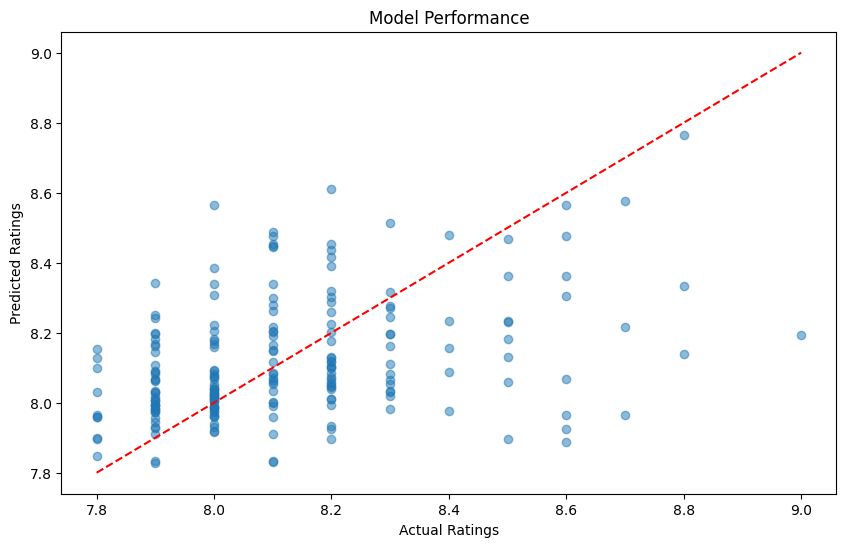

In [99]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Model Performance')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.show()